### Quantum counting using iterative phase estimation
Count the number of solutions in a four-qubit Grover operator marking two states of your choice using iterative QPE with $c$ working qubits. The use of ancilla is optional. You cannot use qiskit's own implementation of any operator except the usual single and two qubit gates. You should show counts plot, the state used for finding the phase, and finally the number of solutions.

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
import numpy as np

In [3]:
def Uo(n=4):
    uo = QuantumCircuit(n)
    uo.h(n-1)
    uo.mcx([0,1,2],3,ctrl_state='010')
    uo.mcx([0,1,2],3,ctrl_state='100')
    uo.h(n-1)
    return uo

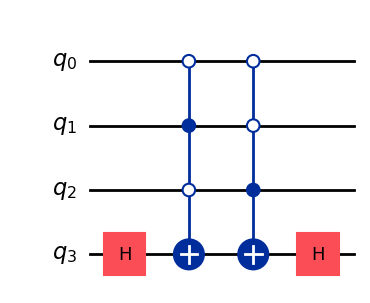

In [4]:
Uo().draw('mpl')

In [5]:
def v_op(n=4, global_phase = np.pi):
    gr = QuantumCircuit(n, global_phase =global_phase)
    gr.h(range(n))
    gr.x(n-1)
    gr.h(n-1)
    gr.mcx([0,1,2],3,ctrl_state='000')
    gr.h(n-1)
    gr.x(n-1)
    gr.h(range(n))
    return gr

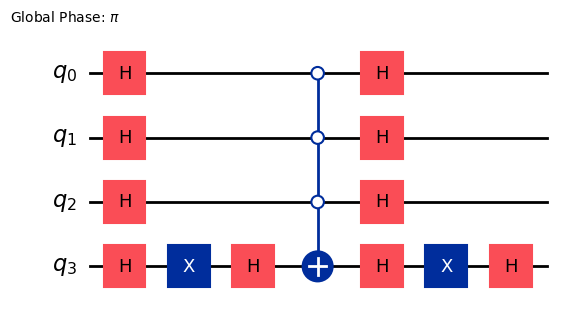

In [6]:
v_op().draw('mpl')

In [7]:
Uo_gate = Uo().to_gate()
Uo_gate.label = "Uo"
Con_Uo =Uo_gate.control()
V_gate = v_op().to_gate()
V_gate.label = "V"
Con_V =V_gate.control()

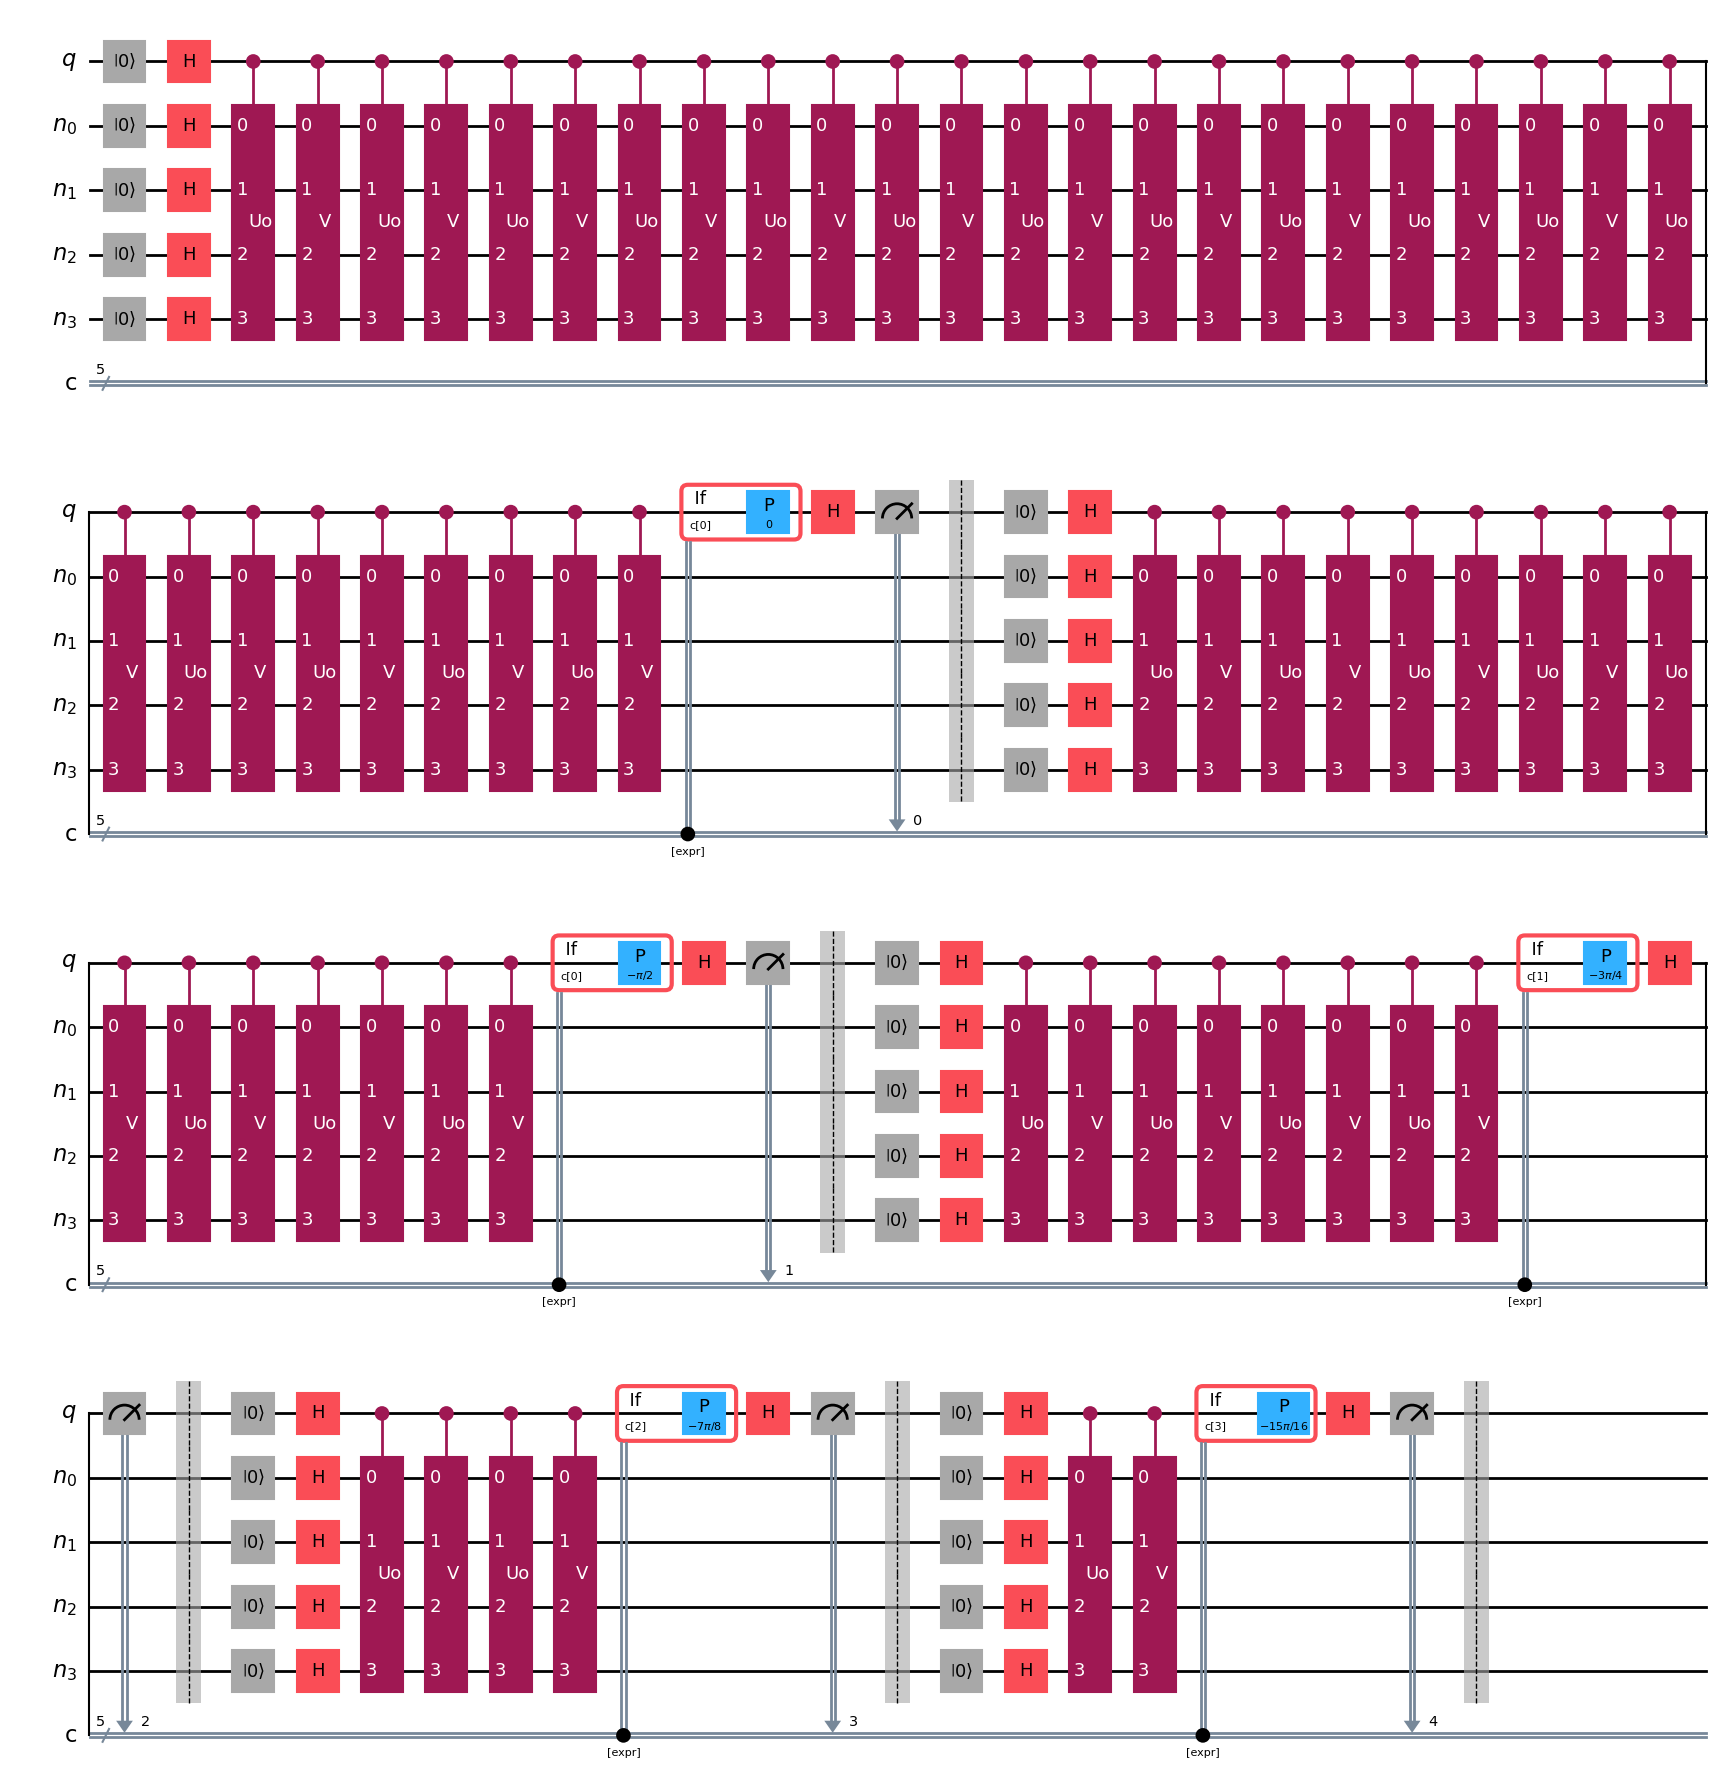

In [9]:
from qiskit.circuit.classical import expr 


c = 5
n = 4

qc = QuantumRegister(1, name='q')
qn = QuantumRegister(n, name='n')
cls = ClassicalRegister(c, name='c')

circuit = QuantumCircuit(qc, qn, cls)


for q in range(c):
    circuit.reset(range(n+1))
    circuit.h(range(1,n+1))
    
    circuit.h(0)
    exp = 2**(c-q-1)
    for i in range(exp):
        circuit.append(Con_Uo, range(n+1))
        circuit.append(Con_V, range(n+1))
        
    theta = 0
    test = expr.lift(cls[0])
    for cr in range(q):
        with circuit.if_test(expr.lift(cls[cr])):
            theta += 2*np.pi/(2**(cr+2))
            test = expr.lift(cls[cr])
    with circuit.if_test(test):
        circuit.p(-theta, 0)


    circuit.h(0)
    circuit.measure(0, cls[q])

    circuit.barrier()

circuit.draw('mpl')

In [10]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
backend = AerSimulator()
circuit_tp = transpile(circuit, backend=backend)
sampler = Sampler(backend)

result = sampler.run([circuit_tp], shots=1000).result()

stats = result[0].data.c.get_counts()
print('states: ', stats)
phase_bit = max(stats, key = lambda k: stats[k])

print(f'phase bit: [ {phase_bit} ]')

phase_int = int(phase_bit, 2)/(2**c)
print(f'phase in decimals: {phase_int:.03f}')
mu = 2**n*np.sin(phase_int*2*np.pi/2)**2
print(f'number of solutions: {mu:.03f}')



states:  {'00101': 42, '11100': 347, '11101': 53, '01100': 52, '00100': 278, '11011': 37, '11110': 3, '10100': 35, '10101': 5, '01011': 8, '00011': 49, '11111': 15, '00000': 4, '01101': 8, '11000': 6, '10011': 5, '00111': 9, '11010': 13, '00010': 21, '01000': 2, '00110': 5, '10010': 1, '01010': 1, '01111': 1}
phase bit: [ 11100 ]
phase in decimals: 0.875
number of solutions: 2.343
